In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,learning_curve

pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

## Import des données

In [2]:
df = pd.read_csv('data_clear.csv')

In [3]:
df= df.sample(n= 50000,random_state=42)

## Train Test Split

In [4]:
X = df.drop(['City', 'CreateJob','RetainedJob', 'RevLineCr',"is_default"], axis=1)
y = df['is_default']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True,stratify=y, random_state=42)

Séparation en categories

In [5]:
numeric_features = ["Term","NoEmp","GrAppv", 'have_franchise', 'in_recession', "LowDoc"]
categorial_features = ["State","BankState","NewExist","UrbanRural","sector"]

Création preprocessor

In [6]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import OneHotEncoder,PolynomialFeatures

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

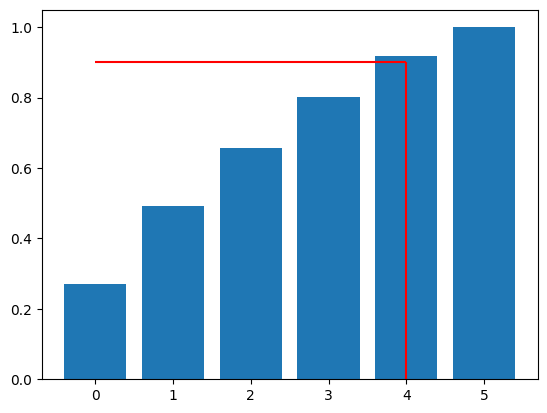

In [7]:
from sklearn.preprocessing import  StandardScaler
import numpy as np
std = StandardScaler()
X_train_standard = std.fit_transform(X_train[numeric_features])

from sklearn.decomposition import PCA
# Choisir le nb de composants
n_dims = X_train_standard.shape[1]
model = PCA(n_components=n_dims)
model.fit(X_train_standard)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

import matplotlib.pyplot as plt
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')

# XGBoost

In [8]:
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

numeric_transformer = Pipeline([
        ('standard', StandardScaler()),  # Centrer réduire
        ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ]
)

numeric_transformer_pca = Pipeline([
        ('standard', StandardScaler()),  # Centrer réduire
        ('pca', PCA(n_components=5)) # après standardisation
        ])
preprocessor_pca = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_pca, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ]
)
bst = XGBClassifier(n_estimators=100, objective='binary:logistic',random_state=42,n_jobs=-1)
bst_pca = XGBClassifier(n_estimators=100, objective='binary:logistic',random_state=42,n_jobs=-1)

pipe_xgboost = Pipeline([
     ('preprocessor', preprocessor),
     ('xgboost', bst)
])

pipe_xgboost_pca = Pipeline([
     ('preprocessor', preprocessor_pca),
     ('xgboost_pca', bst_pca)
])

In [9]:
from sklearn.model_selection import GridSearchCV
def search_best_params(model,X_train,y_train,grid_param:dict,scoring:str):
    """
    The search_best_params function performs a grid search over the hyperparameters of a given model, model, and returns the optimized model.

    The grid search is performed using the GridSearchCV class from the scikit-learn library and the grid_param dictionary specifies the range of hyperparameters to be searched. The scoring argument determines the evaluation metric used to judge the performance of the model during the grid search. The best hyperparameters are selected based on cross-validation performance.

    The optimized model is then returned, with the hyperparameters set to their best values found by the grid search.

    Inputs:

    model: a scikit-learn model object
    X_train: training data features
    y_train: training data labels
    grid_param: a dictionary specifying the range of hyperparameters to be searched
    scoring: string, scoring metric used to evaluate the model performance during grid search

    Returns:

    A scikit-learn model object, with hyperparameters set to their best values found by the grid search.
    """

    grid_src = GridSearchCV(estimator=model, param_grid=grid_param,scoring=scoring,cv=5,verbose=2)
    grid_src.fit(X_train, y_train)
    return grid_src.best_params_



recherche des meilleur params

In [10]:
grid_param = {"xgboost__learning_rate":[0.125,0.15,0.175],"xgboost__scale_pos_weight":[1.75,2,2.25,2.5]}

In [11]:
pipe_xgboost.set_params(**search_best_params(pipe_xgboost,X_train,y_train,grid_param,scoring="f1_macro"))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=1.75; total time=   1.3s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=1.75; total time=   2.2s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=1.75; total time=   1.1s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=1.75; total time=   1.9s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=1.75; total time=   1.5s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=2; total time=   1.3s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=2; total time=   1.1s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=2; total time=   1.3s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=2; total time=   1.2s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_pos_weight=2; total time=   1.3s
[CV] END xgboost__learning_rate=0.125, xgboost__scale_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  ['Term', 'NoEmp', 'GrAppv',
                                                   'have_franchise',
                                                   'in_recession', 'LowDoc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'NewExist', 'UrbanRural',
                                                   'sector'])])),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, call...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.15,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [12]:
grid_param_pca = {"xgboost_pca__learning_rate":[0.125,0.15,0.175],"xgboost_pca__scale_pos_weight":[1.75,2,2.25,2.5]}

In [13]:
pipe_xgboost_pca.set_params(**search_best_params(pipe_xgboost_pca,X_train,y_train,grid_param_pca,scoring="f1_macro"))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END xgboost_pca__learning_rate=0.125, xgboost_pca__scale_pos_weight=1.75; total time=   1.9s
[CV] END xgboost_pca__learning_rate=0.125, xgboost_pca__scale_pos_weight=1.75; total time=   2.6s
[CV] END xgboost_pca__learning_rate=0.125, xgboost_pca__scale_pos_weight=1.75; total time=   2.1s
[CV] END xgboost_pca__learning_rate=0.125, xgboost_pca__scale_pos_weight=1.75; total time=   2.3s
[CV] END xgboost_pca__learning_rate=0.125, xgboost_pca__scale_pos_weight=1.75; total time=   1.9s
[CV] END xgboost_pca__learning_rate=0.125, xgboost_pca__scale_pos_weight=2; total time=   2.6s
[CV] END xgboost_pca__learning_rate=0.125, xgboost_pca__scale_pos_weight=2; total time=   2.0s
[CV] END xgboost_pca__learning_rate=0.125, xgboost_pca__scale_pos_weight=2; total time=   2.0s
[CV] END xgboost_pca__learning_rate=0.125, xgboost_pca__scale_pos_weight=2; total time=   2.0s
[CV] END xgboost_pca__learning_rate=0.125, xgboost_pca__scale_pos_wei

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['Term', 'NoEmp', 'GrAppv',
                                                   'have_franchise',
                                                   'in_recession', 'LowDoc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'NewExist', 'UrbanRural',
                                                   'sector'])])),
                ('xgboost_pca',
                 XGBClassifier(b...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.175, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, predictor=None,
                               random_state=42, ...))])

In [14]:
pipe_xgboost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  ['Term', 'NoEmp', 'GrAppv',
                                                   'have_franchise',
                                                   'in_recession', 'LowDoc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'NewExist', 'UrbanRural',
                                                   'sector'])])),
                ('xgboost',
                 XGBClassifier(base_score=None, booster=None, call...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.15,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [15]:
pipe_xgboost_pca.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  ['Term', 'NoEmp', 'GrAppv',
                                                   'have_franchise',
                                                   'in_recession', 'LowDoc']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['State', 'BankState',
                                                   'NewExist', 'UrbanRural',
                                                   'sector'])])),
                ('xgboost_pca',
                 XGBClassifier(b...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.175, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=100, n_jobs=-1,
                               num_parallel_tree=None, predictor=None,
                               random_state=42, ...))])

In [16]:
pipe_xgboost_pca.predict(X_train)

array([0, 1, 1, ..., 0, 0, 0])

In [17]:
pipe_xgboost.predict(X_train)

array([0, 1, 0, ..., 0, 0, 0])

## Creation instance mlflow

In [18]:
import mlflow
try :
    experiment_id=mlflow.create_experiment("loan_analysis")
except:
    experiment_id=mlflow.get_experiment_by_name("loan_analysis").experiment_id

In [19]:
from sklearn.metrics import f1_score

In [20]:
with mlflow.start_run(experiment_id=experiment_id) as run:


    for param,value in pipe_xgboost[-1].get_params().items():
        mlflow.log_param(param, value)
    mlflow.log_param("PCA", False)

    mlflow.log_metric("Score_train",f1_score(y_train,pipe_xgboost.predict(X_train), average="macro"))
    mlflow.log_metric("Score_test",f1_score(y_test,pipe_xgboost.predict(X_test), average="macro"))


In [21]:
with mlflow.start_run(experiment_id=experiment_id) as run:


    for param,value in pipe_xgboost_pca[-1].get_params().items():
        mlflow.log_param(param, value)
    mlflow.log_param("PCA", True)

    mlflow.log_metric("Score_train",f1_score(y_train,pipe_xgboost_pca.predict(X_train), average="macro"))
    mlflow.log_metric("Score_test",f1_score(y_test,pipe_xgboost_pca.predict(X_test), average="macro"))


## Scoring

In [22]:
from sklearn.model_selection import cross_val_predict
# Utilisation de cross val predict pour gener les predictions du train
pred = cross_val_predict(pipe_xgboost,X_train,y_train,cv=5)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_train,y_pred=pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     37129
           1       0.80      0.82      0.81      7871

    accuracy                           0.93     45000
   macro avg       0.88      0.89      0.88     45000
weighted avg       0.93      0.93      0.93     45000



In [24]:
print(classification_report(y_true=y_train,y_pred=pipe_xgboost.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     37129
           1       0.83      0.87      0.85      7871

    accuracy                           0.95     45000
   macro avg       0.90      0.91      0.91     45000
weighted avg       0.95      0.95      0.95     45000



In [25]:
print(classification_report(y_true=y_test,y_pred=pipe_xgboost.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      4126
           1       0.80      0.83      0.81       874

    accuracy                           0.93      5000
   macro avg       0.88      0.89      0.89      5000
weighted avg       0.93      0.93      0.93      5000



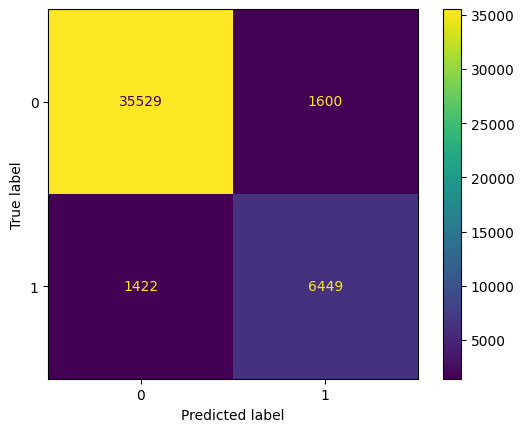

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true=y_train,y_pred=pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_xgboost[-1].classes_)
disp.plot()

plt.show()

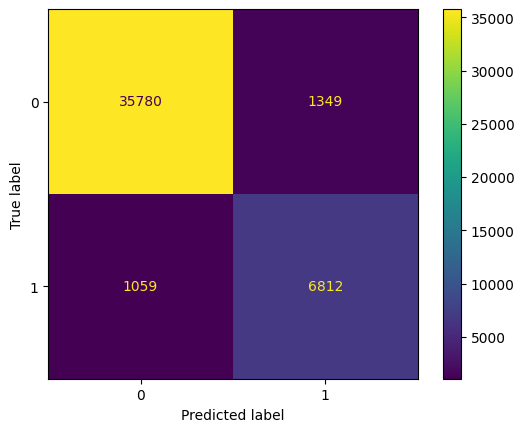

In [27]:
cm = confusion_matrix(y_true=y_train,y_pred=pipe_xgboost.predict(X_train))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_xgboost[-1].classes_)
disp.plot()

plt.show()

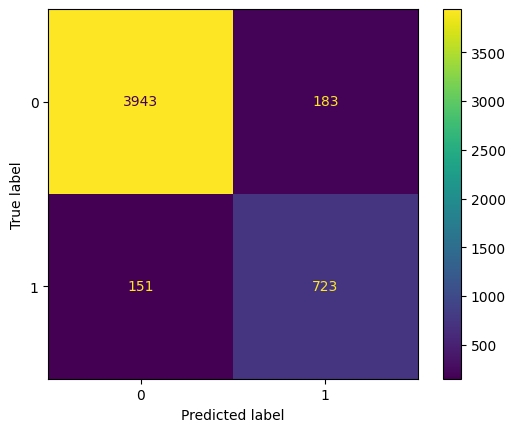

In [28]:
cm = confusion_matrix(y_true=y_test,y_pred=pipe_xgboost.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe_xgboost[-1].classes_)
disp.plot()

plt.show()

### Affichage des learning curve

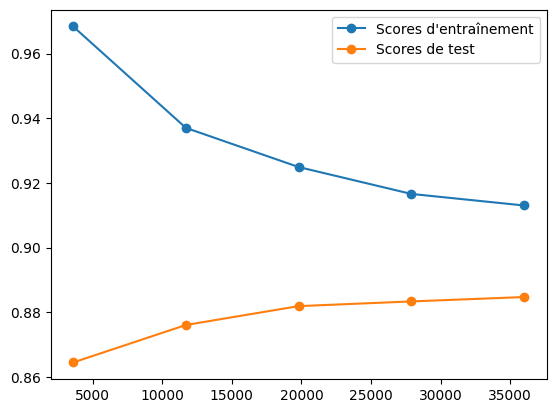

In [29]:
train_sizes, train_scores, test_scores = learning_curve(
    pipe_xgboost, X_train, y_train, cv=5, scoring='f1_macro',train_sizes=np.linspace(0.1,1,5))

train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', label='Scores d\'entraînement')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Scores de test')
plt.legend()
plt.show()

### Affichage des feature importance

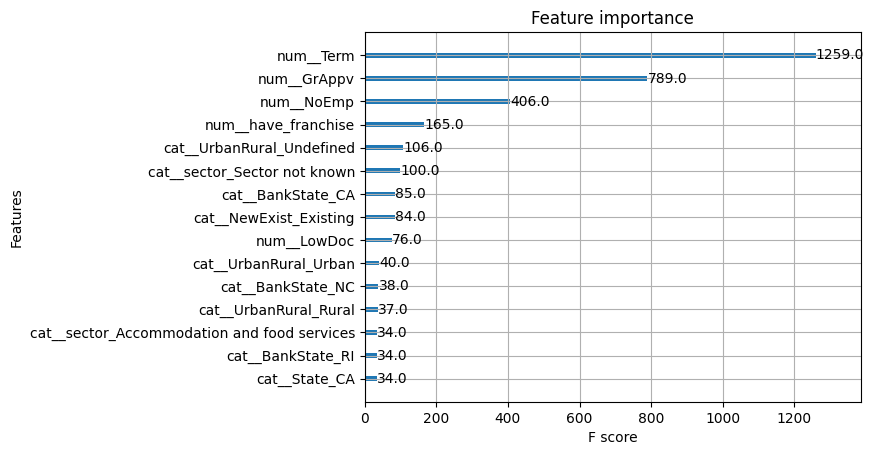

In [30]:
from xgboost import plot_importance

pipe_xgboost[-1].get_booster().feature_names = list(pipe_xgboost[0].get_feature_names_out())
plot_importance(pipe_xgboost[-1],max_num_features=15)
plt.show()